# Homework 3 - Network Dynamics and Learning

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

from scipy.io import loadmat

# 1) Influenza H1N1 2009 Pandemic in Sweden

## 1.1) Get started

### 1.1.1) Pandemic simulation on a given graph

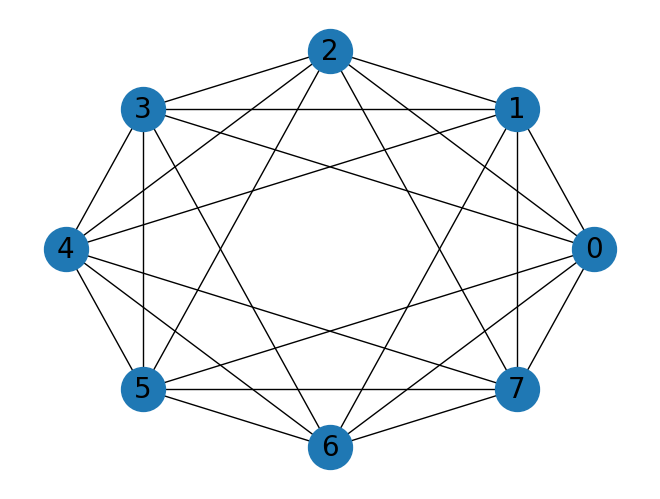

In [ ]:
# Create the symetric k-regular undirected graph
def create_k_regular_graph(n_nodes=500, k=6):
    """
    Create a k-regular graph where each node connects to k nearest neighbors
    """
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(-(k//2), (k//2) + 1):
            if j != 0:
                neighbor = (i + j) % n_nodes
                rows.extend([i, neighbor])
                cols.extend([neighbor, i])
    
    data = np.ones(len(rows))
    return sparse.csr_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes))

# Replicate the graph from the homework sheet
n_nodes = 8
k = 6
A = create_k_regular_graph(n_nodes, k)
G = nx.from_scipy_sparse_array(A)
nx.draw_circular(G, with_labels=True, font_size=20, node_size=1000)

In [3]:
# Epidemic simulation function
def simulate_epidemic_step(states, adjacency, beta, rho): #CHOSE ONE OF THE 2 FUNCTIONS
    """
    Simulate one step of the epidemic
    """
    # Find infected nodes
    infected_nodes = states == 1
    # Calculate infection probabilities
    infection_matrix = adjacency.multiply(sparse.csr_matrix(infected_nodes).T)
    infection_counts = np.array(infection_matrix.sum(axis=0)).flatten() 
    infection_probs = 1 - (1 - beta) ** infection_counts
    
    # Process new infections
    susceptible_nodes = states == 0
    new_infections = np.random.random(len(states)) < infection_probs * susceptible_nodes
    states[new_infections] = 1
    
    
    # Process recoveries
    recoveries = np.random.random(len(states)) < rho * infected_nodes
    states[recoveries] = 2
    
    return states, np.sum(new_infections)

In [4]:
# Simulation parameters
n_nodes = 500
k = 6
beta = 0.25
rho = 0.6
weeks = 15
n_simulations = 100
n_initial_infected = 10

# Create graph
G = create_k_regular_graph(n_nodes, k)

# Initialize results storage
results = {
    'new_infected': np.zeros((n_simulations, weeks)),
    'susceptible': np.zeros((n_simulations, weeks)),
    'infected': np.zeros((n_simulations, weeks)),
    'recovered': np.zeros((n_simulations, weeks))
}

# Run simulations
for sim in tqdm(range(n_simulations), desc="Running simulations"):
    # Initialize states
    states = np.zeros(n_nodes)
    initial_infected = np.random.choice(n_nodes, n_initial_infected, replace=False)
    states[initial_infected] = 1
    
    # Simulate weeks
    for week in range(weeks):
        # Record current state
        results['susceptible'][sim, week] = np.sum(states == 0)
        results['infected'][sim, week] = np.sum(states == 1)
        results['recovered'][sim, week] = np.sum(states == 2)
        
        # Simulate epidemic spread
        states, new_infections = simulate_epidemic_step(states, G, beta, rho)
        results['new_infected'][sim, week] = new_infections

# Calculate averages
avg_results = {k: np.mean(v, axis=0) for k, v in results.items()}

Running simulations: 100%|██████████| 100/100 [00:00<00:00, 400.84it/s]


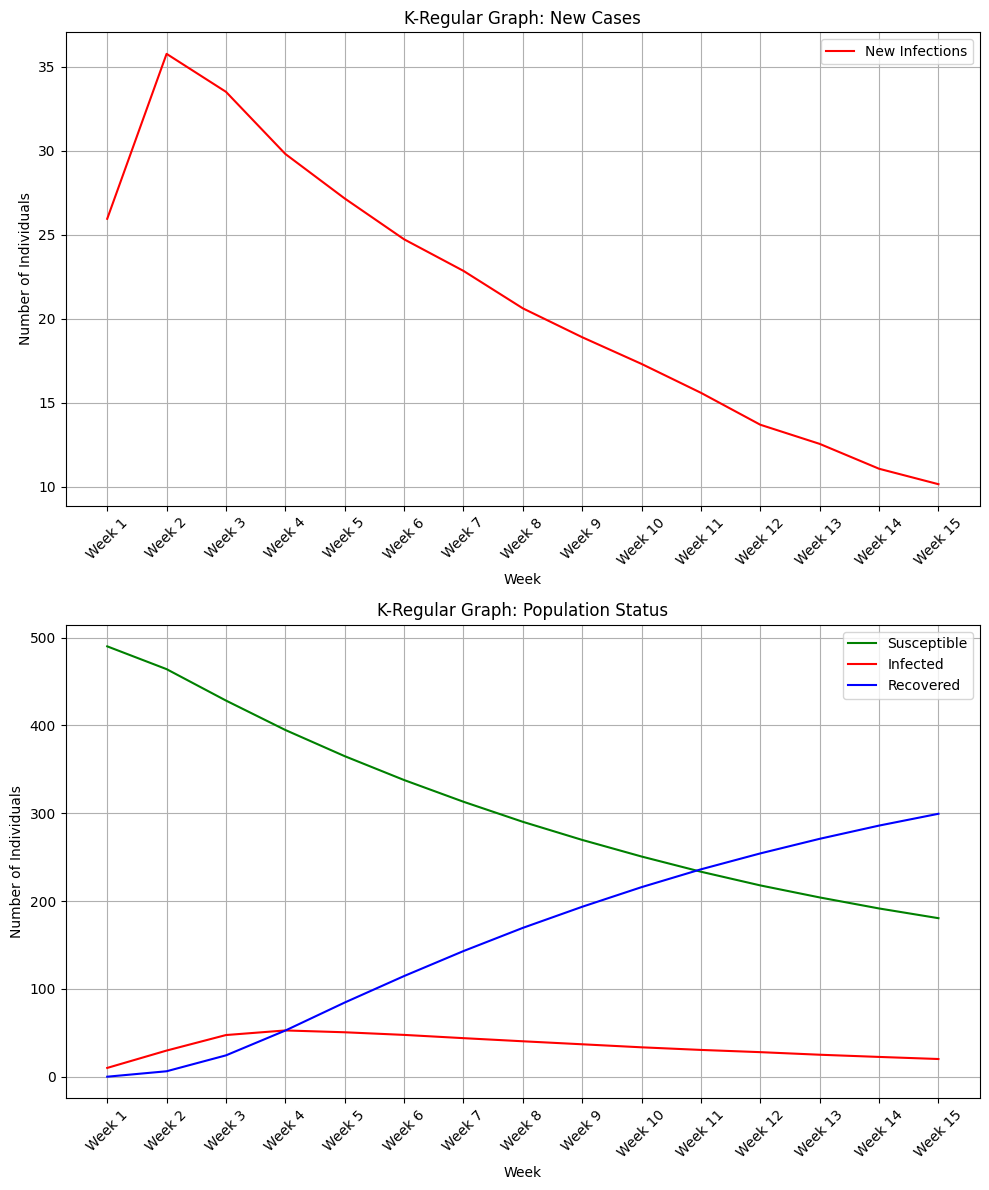

In [5]:
# Plot results
def plot_epidemic_results(results, title_prefix="Epidemic Simulation"):
    """Plot epidemic simulation results"""
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot new infections
    ax1.plot(range(1, weeks + 1), results['new_infected'], 'r-', label='New Infections')
    ax1.set_xlabel('Week')
    ax1.set_ylabel('Number of Individuals')
    ax1.set_title(f'{title_prefix}: New Cases')
    ax1.legend()
    ax1.grid(True)
    
    # Plot total numbers
    ax2.plot(range(1, weeks + 1), results['susceptible'], 'g-', label='Susceptible')
    ax2.plot(range(1, weeks + 1), results['infected'], 'r-', label='Infected')
    ax2.plot(range(1, weeks + 1), results['recovered'], 'b-', label='Recovered')
    ax2.set_xlabel('Week')
    ax2.set_ylabel('Number of Individuals')
    ax2.set_title(f'{title_prefix}: Population Status')
    ax2.legend()
    ax2.grid(True)
    
    # Set x-ticks
    weeks_labels = [f'Week {i}' for i in range(1, weeks + 1)]
    ax1.set_xticks(range(1, weeks + 1))
    ax1.set_xticklabels(weeks_labels, rotation=45)
    ax2.set_xticks(range(1, weeks + 1))
    ax2.set_xticklabels(weeks_labels, rotation=45)
    
    plt.tight_layout()
    
plot_epidemic_results(avg_results, "K-Regular Graph")

### 1.1.2) Pandemic simulation on a random graph

In [6]:
# Generate a Random Graph
def create_preferential_attachment_graph(n_nodes=500, k=6):
    """
    Generate a random graph using the preferential attachment model.
    """
    # Start with a complete graph of k+1 nodes
    n_initial = k + 1
    adjacency = np.ones((n_initial, n_initial)) - np.eye(n_initial)
    
    # Initialize c values for alternating between ⌊k/2⌋ and ⌈k/2⌉ when k is odd
    c_low = k // 2
    c_high = c_low + 1 if k % 2 == 1 else c_low
    toggle = False  # Track which c to use
    
    # Add new nodes with preferential attachment
    for i in range(n_initial, n_nodes):
        degrees = np.sum(adjacency, axis=1)
        probs = degrees / np.sum(degrees)
        
        # Alternate between c_low and c_high
        c = c_high if toggle else c_low
        toggle = not toggle
        
        # Select nodes to connect to
        new_connections = np.random.choice(i, size=c, replace=False, p=probs[:i])
        
        # Expand adjacency matrix
        adjacency = np.pad(adjacency, ((0, 1), (0, 1)))
        
        # Add new connections
        for j in new_connections:
            adjacency[i, j] = adjacency[j, i] = 1
    
    return sparse.csr_matrix(adjacency)

In [7]:
n_nodes = 90
k = 6

# Create graph
G_random = create_preferential_attachment_graph(n_nodes, k)
avg_degree = np.mean(G_random.sum(axis=1))
print(f"Average degree of generated graph: {avg_degree}")

Average degree of generated graph: 6.0


In [8]:
n_nodes = 90
k = 7

# Create graph
G_random = create_preferential_attachment_graph(n_nodes, k)
avg_degree = np.mean(G_random.sum(axis=1))
print(f"Average degree of generated graph: {avg_degree}")

Average degree of generated graph: 7.0


## 1.2) Simulate a Pandemic Without Vaccination

Average degree of generated graph: 6.0


Running simulations: 100%|██████████| 100/100 [00:00<00:00, 388.62it/s]


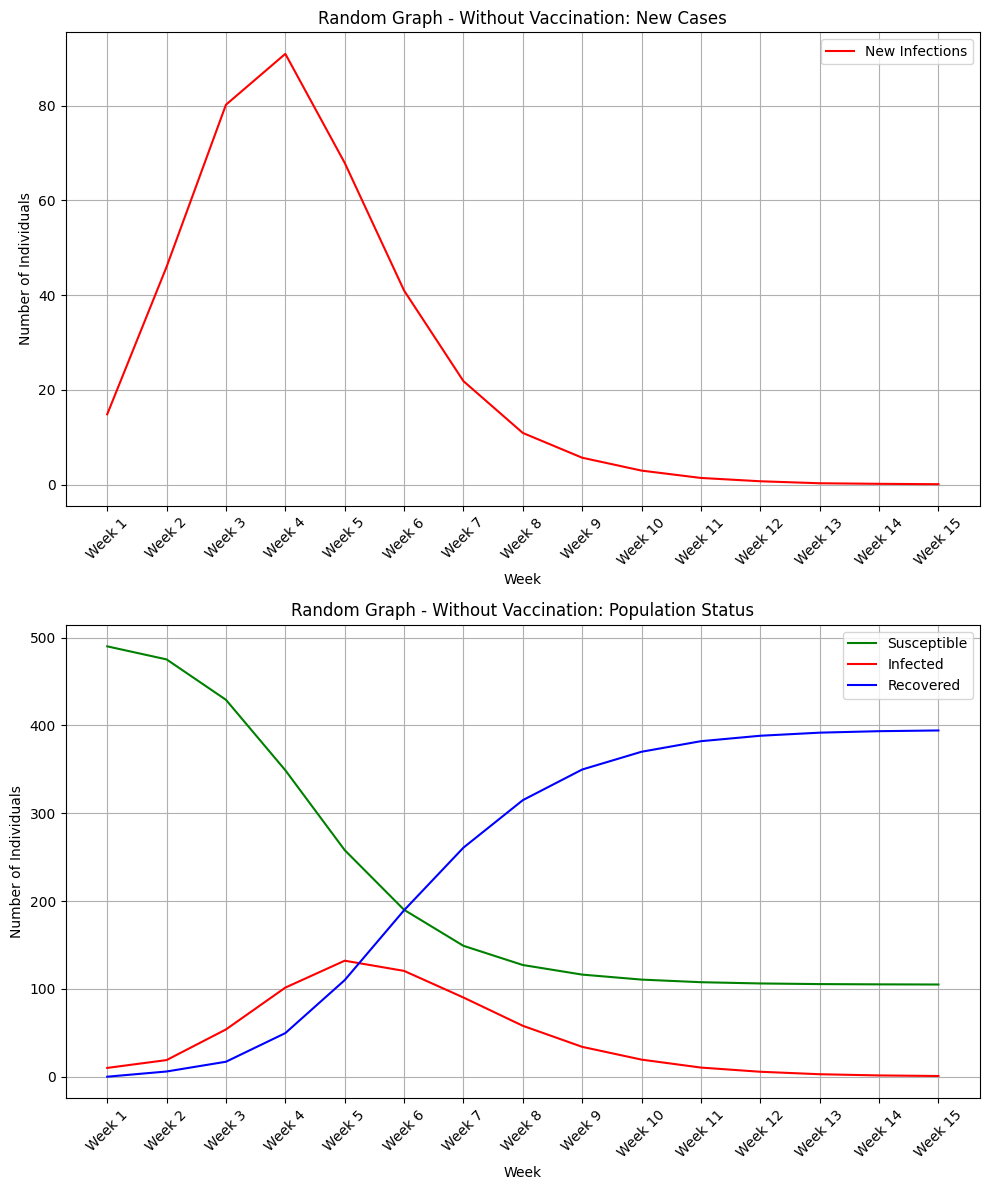

In [9]:
# Simulation parameters
n_nodes = 500
k = 6
beta = 0.25
rho = 0.6
weeks = 15
n_simulations = 100
n_initial_infected = 10

# Create graph
G_random = create_preferential_attachment_graph(n_nodes, k)
avg_degree = np.mean(G_random.sum(axis=1))
print(f"Average degree of generated graph: {avg_degree}")

# Initialize results storage
results = {
    'new_infected': np.zeros((n_simulations, weeks)),
    'susceptible': np.zeros((n_simulations, weeks)),
    'infected': np.zeros((n_simulations, weeks)),
    'recovered': np.zeros((n_simulations, weeks))
}

# Run simulations
for sim in tqdm(range(n_simulations), desc="Running simulations"):
    # Initialize states
    states = np.zeros(n_nodes)
    initial_infected = np.random.choice(n_nodes, n_initial_infected, replace=False)
    states[initial_infected] = 1
    
    # Simulate weeks
    for week in range(weeks):
        # Record current state
        results['susceptible'][sim, week] = np.sum(states == 0)
        results['infected'][sim, week] = np.sum(states == 1)
        results['recovered'][sim, week] = np.sum(states == 2)
        
        # Simulate epidemic spread
        states, new_infections = simulate_epidemic_step(states, G_random, beta, rho)
        results['new_infected'][sim, week] = new_infections

# Calculate averages
avg_results = {k: np.mean(v, axis=0) for k, v in results.items()}
# Plot results
plot_epidemic_results(avg_results, "Random Graph - Without Vaccination")

## 1.3) Simulate a Pandemic With Vaccination

In [10]:
def simulate_epidemic_with_vaccination(states, adjacency, beta, rho, vacc_rate):
    """
    Simulate one step of the epidemic with vaccination
    """
    # Process vaccinations
    n_nodes = len(states)
    n_new_vaccinated = int(n_nodes * vacc_rate / 100)
    eligible = np.where(states != 3)[0]
    n_vaccinated = 0
    
    if len(eligible) > 0:
        to_vaccinate = np.random.choice(eligible, 
            size=min(n_new_vaccinated, len(eligible)), replace=False)
        states[to_vaccinate] = 3
        n_vaccinated = len(to_vaccinate)
    
    # Process infections (only for non-vaccinated)
    infected_nodes = states == 1
    infection_matrix = adjacency.multiply(sparse.csr_matrix(infected_nodes).T)
    infection_counts = np.array(infection_matrix.sum(axis=0)).flatten()
    infection_probs = 1 - (1 - beta) ** infection_counts
    
    susceptible_nodes = states == 0
    new_infections = np.random.random(n_nodes) < infection_probs * susceptible_nodes
    states[new_infections] = 1
    
    # Process recoveries (only for non-vaccinated)
    recoveries = np.random.random(n_nodes) < rho * infected_nodes
    states[recoveries] = 2
    
    return states, np.sum(new_infections), n_vaccinated

Running simulations (with vaccination): 100%|██████████| 100/100 [00:00<00:00, 358.67it/s]


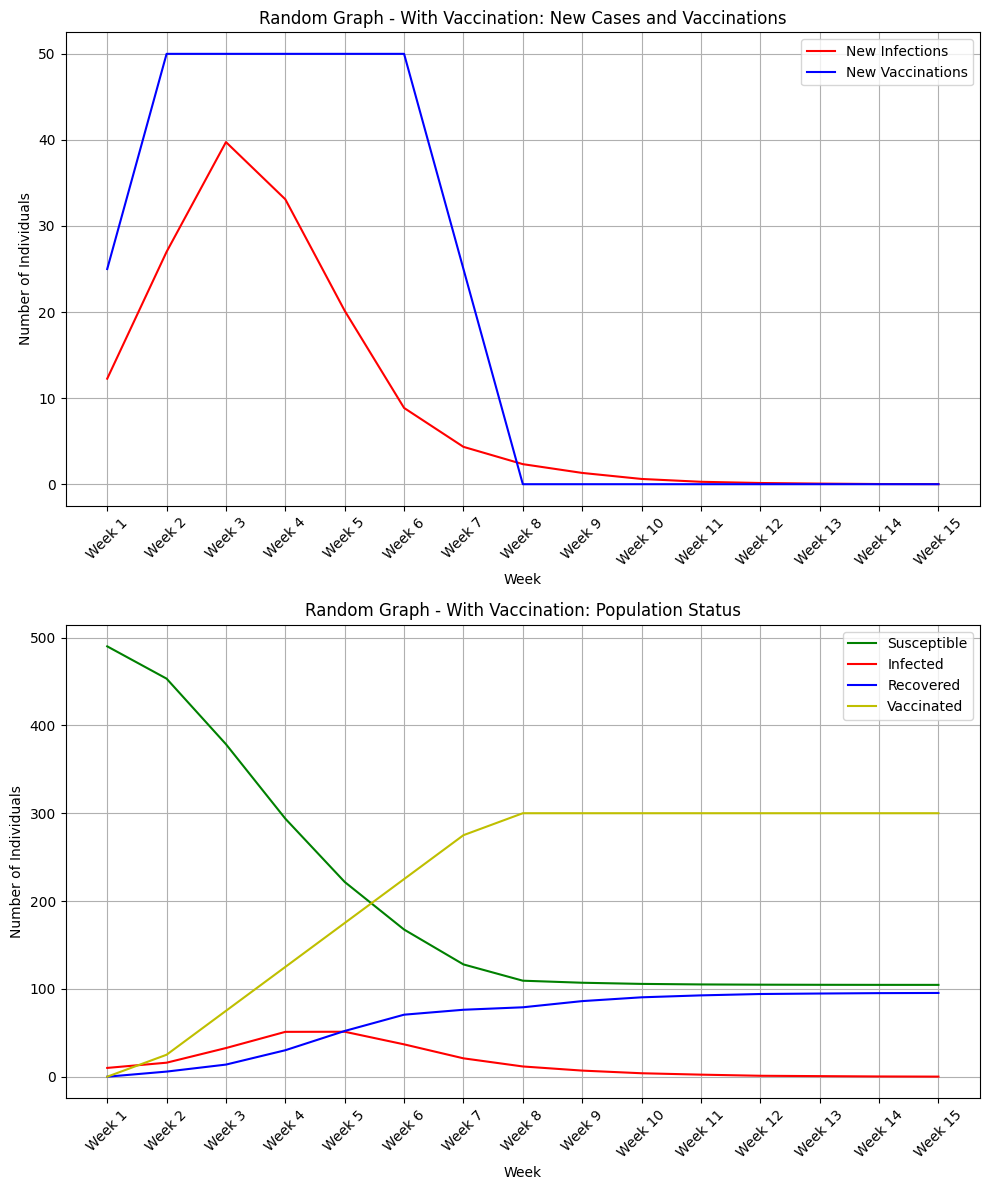

In [36]:
# Simulation parameters
n_nodes = 500
k = 6
beta = 0.25
rho = 0.6
weeks = 15
n_simulations = 100
n_initial_infected = 10

# Vaccination schedule
vacc_schedule = [0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]

# Initialize results
results_vacc = {
    'new_infected': np.zeros((n_simulations, weeks)),
    'new_vaccinated': np.zeros((n_simulations, weeks)),
    'susceptible': np.zeros((n_simulations, weeks)),
    'infected': np.zeros((n_simulations, weeks)),
    'recovered': np.zeros((n_simulations, weeks)),
    'vaccinated': np.zeros((n_simulations, weeks))
}

# Run simulations
for sim in tqdm(range(n_simulations), desc="Running simulations (with vaccination)"):
    states = np.zeros(n_nodes)
    
    # Infect initial population
    initial_infected = np.random.choice(n_nodes, n_initial_infected, replace=False)
    states[initial_infected] = 1
    
    # Vaccinate initial population
    n_new_vaccinated = int(n_nodes * vacc_schedule[0] / 100)
    initial_vaccinated = np.random.choice(n_nodes, n_new_vaccinated, replace=False)
    states[initial_vaccinated] = 3
    
    for week in range(weeks):
        
        # Calculate vaccination rate for this week
        vacc_rate = vacc_schedule[week + 1] - vacc_schedule[week] if week < weeks - 1 else 0
        
        # Record current state
        results_vacc['susceptible'][sim, week] = np.sum(states == 0)
        results_vacc['infected'][sim, week] = np.sum(states == 1)
        results_vacc['recovered'][sim, week] = np.sum(states == 2)
        results_vacc['vaccinated'][sim, week] = np.sum(states == 3)
        
        # Simulate epidemic spread with vaccination
        states, new_infections, new_vaccinations = simulate_epidemic_with_vaccination(
            states, G_random, beta, rho, vacc_rate)
        
        results_vacc['new_infected'][sim, week] = new_infections
        results_vacc['new_vaccinated'][sim, week] = new_vaccinations

# Calculate averages
avg_results_vacc = {k: np.mean(v, axis=0) for k, v in results_vacc.items()}

# Plot results
def plot_epidemic_results_with_vaccination(results, title_prefix="Epidemic Simulation"):
    """Plot epidemic simulation results including vaccination data"""
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot new cases
    ax1.plot(range(1, weeks + 1), results['new_infected'], 'r-', label='New Infections')
    ax1.plot(range(1, weeks + 1), results['new_vaccinated'], 'b-', label='New Vaccinations')
    ax1.set_xlabel('Week')
    ax1.set_ylabel('Number of Individuals')
    ax1.set_title(f'{title_prefix}: New Cases and Vaccinations')
    ax1.legend()
    ax1.grid(True)
    
    # Plot total numbers
    ax2.plot(range(1, weeks + 1), results['susceptible'], 'g-', label='Susceptible')
    ax2.plot(range(1, weeks + 1), results['infected'], 'r-', label='Infected')
    ax2.plot(range(1, weeks + 1), results['recovered'], 'b-', label='Recovered')
    ax2.plot(range(1, weeks + 1), results['vaccinated'], 'y-', label='Vaccinated')
    ax2.set_xlabel('Week')
    ax2.set_ylabel('Number of Individuals')
    ax2.set_title(f'{title_prefix}: Population Status')
    ax2.legend()
    ax2.grid(True)
    
    # Set x-ticks
    weeks_labels = [f'Week {i}' for i in range(1, weeks + 1)]
    ax1.set_xticks(range(1, weeks + 1))
    ax1.set_xticklabels(weeks_labels, rotation=45)
    ax2.set_xticks(range(1, weeks + 1))
    ax2.set_xticklabels(weeks_labels, rotation=45)
    
    plt.tight_layout()

plot_epidemic_results_with_vaccination(avg_results_vacc, "Random Graph - With Vaccination")


## 1.4) The H1N1 Pandemic in Sweden 2009 

Testing parameter combinations: 100%|██████████| 27/27 [00:10<00:00,  2.49it/s]

Best parameters found:
k = 10
β = 0.200
ρ = 0.700
RMSE = 3.588


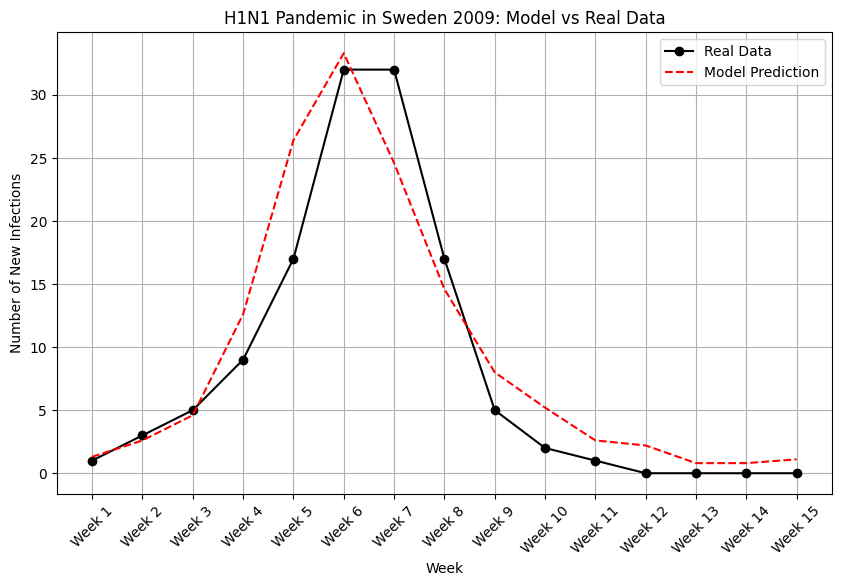

In [47]:

def compute_rmse(simulated_data, real_data):
        """Compute Root Mean Square Error"""
        return np.sqrt(np.mean((simulated_data - real_data) ** 2))
    
def estimate_parameters(n_nodes=934, initial_params={'k': 10, 'beta': 0.3, 'rho': 0.6}, 
                       delta={'k': 1, 'beta': 0.1, 'rho': 0.1}, real_data=None,
                       vacc_schedule=None, n_simulations=10, weeks=15):
    """
    Estimate epidemic parameters using gradient-based search
    """
    
    best_params = initial_params.copy()
    best_rmse = float('inf')
    best_results = None
    
    while True:
        # Generate parameter combinations to test
        param_combinations = []
        for k in [best_params['k'] - delta['k'], best_params['k'], best_params['k'] + delta['k']]:
            for beta in [best_params['beta'] - delta['beta'], best_params['beta'], best_params['beta'] + delta['beta']]:
                for rho in [best_params['rho'] - delta['rho'], best_params['rho'], best_params['rho'] + delta['rho']]:
                    if k > 0 and 0 <= beta <= 1 and 0 <= rho <= 1:
                        param_combinations.append({'k': k, 'beta': beta, 'rho': rho})
        
        # Test each parameter combination
        improved = False
        for params in tqdm(param_combinations, desc="Testing parameter combinations"):
            # Create network
            G = create_preferential_attachment_graph(n_nodes=n_nodes, k=int(params['k']))
            # Run multiple simulations
            all_new_infected = np.zeros((n_simulations, weeks))
            
            for sim in range(n_simulations):
                states = np.zeros(n_nodes)
                
                # Infect initial population
                initial_infected = np.random.choice(n_nodes, real_data[0], replace=False)
                states[initial_infected] = 1
                
                # Vaccinate initial population
                n_new_vaccinated = int(n_nodes * vacc_schedule[0] / 100)
                initial_vaccinated = np.random.choice(n_nodes, n_new_vaccinated, replace=False)
                states[initial_vaccinated] = 3
                
                for week in range(weeks):
                    # Calculate vaccination rate for this week
                    vacc_rate = vacc_schedule[week + 1] - vacc_schedule[week] if week < weeks - 1 else 0
                    states, new_infections, _ = simulate_epidemic_with_vaccination(
                        states, G, params['beta'], params['rho'], vacc_rate)
                    
                    all_new_infected[sim, week] = new_infections
            
            # Compute average new infections and RMSE
            avg_new_infected = np.mean(all_new_infected, axis=0)
            rmse = compute_rmse(avg_new_infected, real_data[1:])
            
            # Update best parameters if improved
            if rmse < best_rmse:
                best_rmse = rmse
                best_params = params.copy()
                best_results = {'new_infected': avg_new_infected}
                improved = True
        
        # If no improvement, reduce step sizes or stop
        if not improved:
            delta = {k: v/2 for k, v in delta.items()}
            if all(v < 0.01 for v in delta.values()):
                break

    return best_params, best_rmse, best_results


# Real data from Sweden (scaled down by 10^4)
sweden_data = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])

# Vaccination schedule for Sweden (percentage of population)
sweden_vacc = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60])

# Initial parameters and step sizes
initial_params = {'k': 10, 'beta': 0.3, 'rho': 0.6}
initial_delta = {'k': 1, 'beta': 0.1, 'rho': 0.1}

# Run parameter estimation
best_params, best_rmse, best_results = estimate_parameters(
    n_nodes=934,
    initial_params=initial_params,
    delta=initial_delta,
    real_data=sweden_data,
    vacc_schedule=sweden_vacc
)

print("Best parameters found:")
print(f"k = {best_params['k']}")
print(f"β = {best_params['beta']:.3f}")
print(f"ρ = {best_params['rho']:.3f}")
print(f"RMSE = {best_rmse:.3f}")

# Plot results
def plot_model_comparison(real_data, model_results):
    """Plot comparison between model predictions and real data"""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, weeks + 1), real_data, 'ko-', label='Real Data')
    plt.plot(range(1, weeks + 1), model_results['new_infected'], 'r--', label='Model Prediction')
    plt.xlabel('Week')
    plt.ylabel('Number of New Infections')
    plt.title('H1N1 Pandemic in Sweden 2009: Model vs Real Data')
    plt.legend()
    plt.grid(True)
    
    # Set x-ticks
    weeks_labels = [f'Week {i}' for i in range(1, weeks + 1)]
    plt.xticks(ticks=range(1, weeks + 1), labels=weeks_labels, rotation=45)
    
    plt.show()

plot_model_comparison(sweden_data[1:], best_results)

Running simulations (with vaccination): 100%|██████████| 100/100 [00:00<00:00, 298.87it/s]


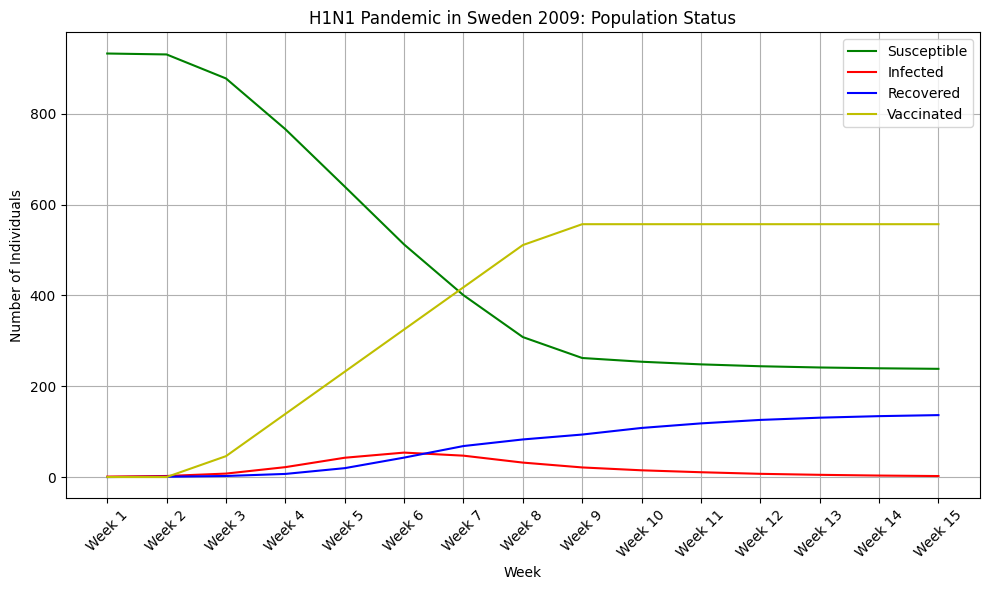

In [63]:
# Simulation parameters
n_nodes = 934
k = round(best_params['k'])
beta = best_params['beta']
rho = best_params['rho']
weeks = 15
n_simulations = 100
n_initial_infected = sweden_data[0]

# Create graph
G = create_preferential_attachment_graph(n_nodes, k)

# Initialize results
results_vacc = {
    'new_infected': np.zeros((n_simulations, weeks)),
    'new_vaccinated': np.zeros((n_simulations, weeks)),
    'susceptible': np.zeros((n_simulations, weeks)),
    'infected': np.zeros((n_simulations, weeks)),
    'recovered': np.zeros((n_simulations, weeks)),
    'vaccinated': np.zeros((n_simulations, weeks))
}

# Run simulations
for sim in tqdm(range(n_simulations), desc="Running simulations (with vaccination)"):
    states = np.zeros(n_nodes)
    initial_infected = np.random.choice(n_nodes, n_initial_infected, replace=False)
    states[initial_infected] = 1
    
    for week in range(weeks):
        # Calculate vaccination rate for this week
        vacc_rate = vacc_schedule[week] - (vacc_schedule[week-1] if week > 0 else 0)
        
        # Record current state
        results_vacc['susceptible'][sim, week] = np.sum(states == 0)
        results_vacc['infected'][sim, week] = np.sum(states == 1)
        results_vacc['recovered'][sim, week] = np.sum(states == 2)
        results_vacc['vaccinated'][sim, week] = np.sum(states == 3)
        
        # Simulate epidemic spread with vaccination
        states, new_infections, new_vaccinations = simulate_epidemic_with_vaccination(
            states, G, beta, rho, vacc_rate)
        
        results_vacc['new_infected'][sim, week] = new_infections
        results_vacc['new_vaccinated'][sim, week] = new_vaccinations

# Calculate averages
avg_results_vacc = {k: np.mean(v, axis=0) for k, v in results_vacc.items()}

# Plot results
plt.figure(figsize=(10, 6))

plt.plot(range(1, weeks + 1), avg_results_vacc['susceptible'], 'g-', label='Susceptible')
plt.plot(range(1, weeks + 1), avg_results_vacc['infected'], 'r-', label='Infected')
plt.plot(range(1, weeks + 1), avg_results_vacc['recovered'], 'b-', label='Recovered')
plt.plot(range(1, weeks + 1), avg_results_vacc['vaccinated'], 'y-', label='Vaccinated')
plt.xlabel('Week')
plt.ylabel('Number of Individuals')
plt.title('H1N1 Pandemic in Sweden 2009: Population Status')
plt.legend()
plt.grid(True)

# Set x-ticks
weeks_labels = [f'Week {i}' for i in range(1, weeks + 1)]
plt.xticks(range(1, weeks + 1), weeks_labels, rotation=45)

plt.tight_layout()
plt.show()


# 2) Coloring

## 2.1) Simple line graph

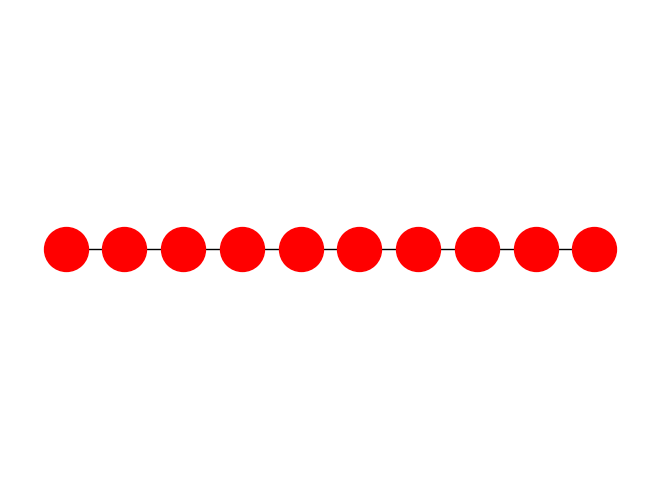

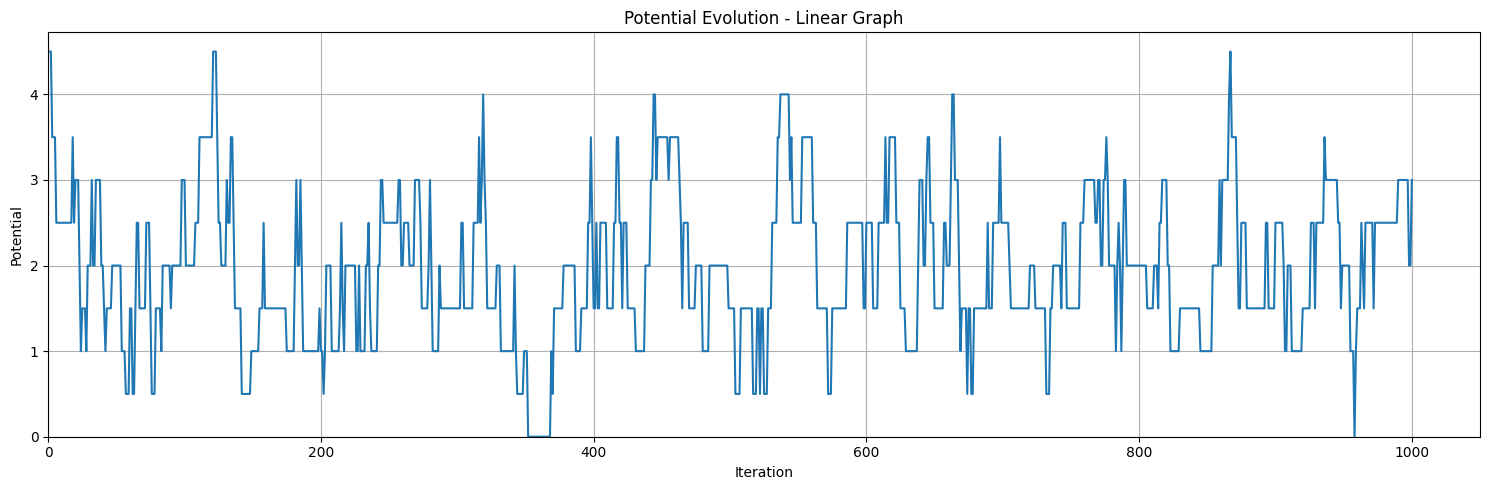

In [133]:
## Functions for Coloring Dynamics

def calculate_node_costs(adj_matrix, node, state, color, cost_func):
    """Calculate the total cost for a node if it chooses a specific color."""
    neighbors = np.where(adj_matrix[node] > 0)[0]
    return sum(cost_func(color, state[neighbor]) for neighbor in neighbors)

def calculate_potential(adj_matrix, state, cost_func):
    """Calculate the total potential of the current state."""
    potential = 0
    num_nodes = adj_matrix.shape[0]
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if adj_matrix[i, j]:
                potential += cost_func(state[i], state[j])
    return potential/2

def update_probability(adj_matrix, node, state, t, colors, eta_func, cost_func):
    """Calculate the probability distribution for color selection."""
    costs = np.array([calculate_node_costs(adj_matrix, node, state, color, cost_func) 
                      for color in colors])
    eta = eta_func(t)
    exp_terms = np.exp(-eta * costs)
    return exp_terms / np.sum(exp_terms)

def simulate(adj_matrix, colors, eta_func, cost_func, num_iterations, initial_state=None):
    """
    Simulate the coloring dynamics.
    """
    num_nodes = adj_matrix.shape[0]
    current_state = (initial_state if initial_state is not None else np.random.choice(colors, num_nodes))
    
    potential_history = [calculate_potential(adj_matrix, current_state, cost_func)]
    states_history = [current_state.copy()]
    
    for t in range(num_iterations):
        node = np.random.randint(num_nodes)
        probs = update_probability(adj_matrix, node, current_state, t, colors, eta_func, cost_func)
        current_state[node] = np.random.choice(colors, p=probs)
        
        potential_history.append(calculate_potential(adj_matrix, current_state, cost_func))
        states_history.append(current_state.copy())
        
    return states_history, potential_history

def create_line_graph(n):
    """Create a linear graph with n nodes."""
    adj_matrix = np.zeros((n, n))
    for i in range(n-1):
        adj_matrix[i, i+1] = adj_matrix[i+1, i] = 1
    return adj_matrix

def binary_cost(color1, color2):
    """Binary cost function for the linear graph."""
    return 1.0 if color1 == color2 else 0.0




# Parameters for the linear graph
n_nodes = 10
colors = ['red', 'green']
eta_func = lambda t: t/ 50

# Create and initialize the simulation
line_graph = create_line_graph(n_nodes)

# Draw the graph using networkx

G = nx.from_numpy_array(line_graph)
pos = {i: (i, 0) for i in range(n_nodes)}
nx.draw(G, pos, node_color='red', node_size=1000, with_labels=False)


# Initial state: all nodes red
initial_state = np.array(['red'] * n_nodes)

# Run the simulation
n_iterations = 1000
states_history, potential_history = simulate(line_graph, colors, eta_func, binary_cost, n_iterations, initial_state)

# Plot results
plt.figure(figsize=(15, 5))
plt.plot(potential_history)
plt.title('Potential Evolution - Linear Graph')
plt.xlabel('Iteration')
plt.ylabel('Potential')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.2) Wifi-Channel Assignment

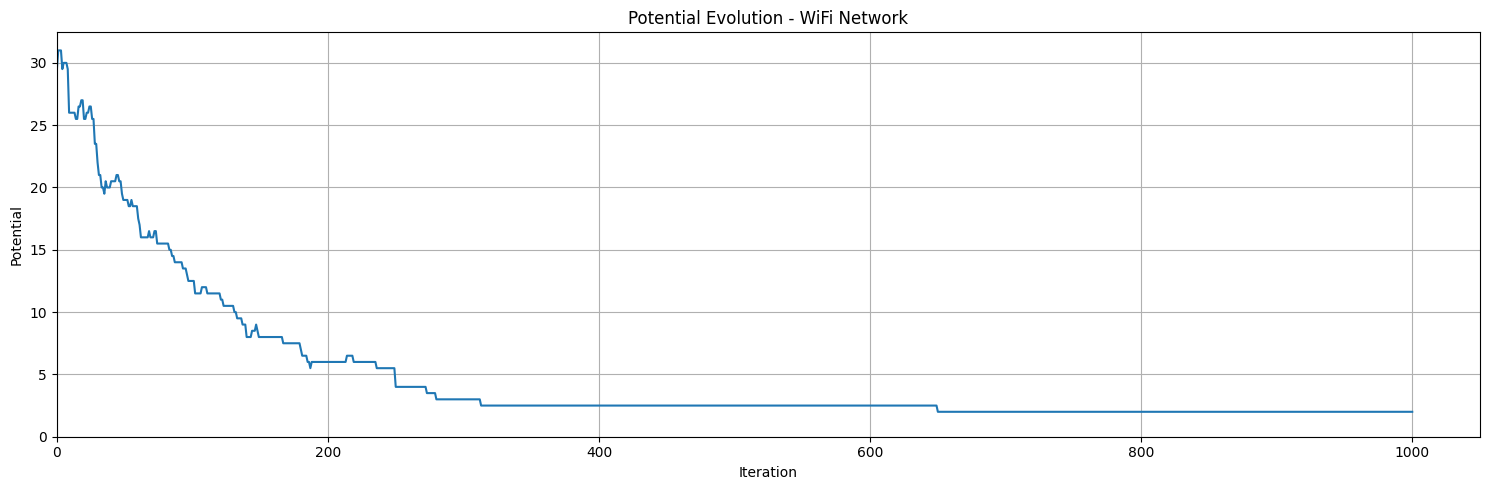

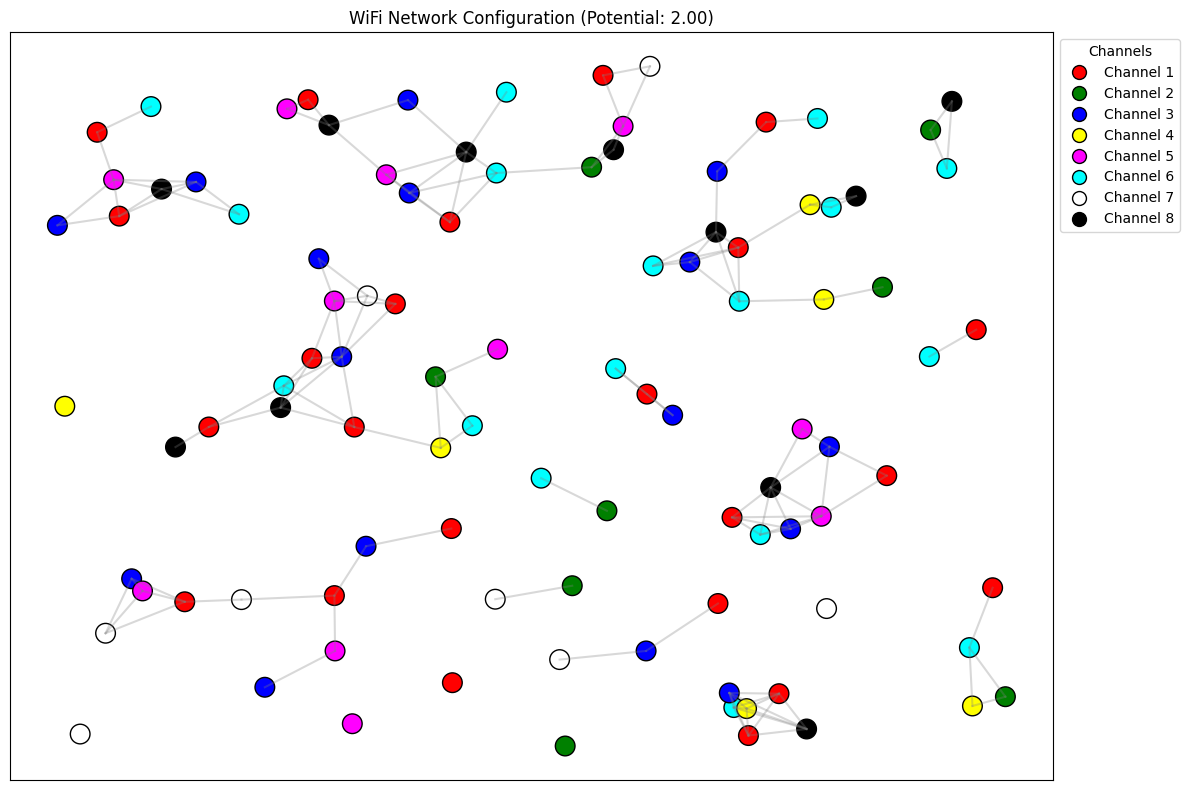

In [119]:
def wifi_cost(color1, color2):
    """
    Cost function for WiFi channels:
    - 2 if same channel
    - 1 if adjacent channels
    - 0 otherwise
    """
    if color1 == color2:
        return 2
    elif abs(color1 - color2) == 1:
        return 1
    return 0

# Load data
wifi_data = loadmat('wifi.mat')
coord_data = loadmat('coords.mat')
adj_matrix = wifi_data['wifi']
coordinates = coord_data['coords']

# Parameters for WiFi simulation
wifi_channels = list(range(1, 9))  # 8 channels
eta_func = lambda t: t / 50

# Run simulation
n_iterations = 1000
states_history, potential_history = simulate(adj_matrix, wifi_channels, eta_func, wifi_cost, n_iterations)

# Plot potential evolution
plt.figure(figsize=(15, 5))
plt.plot(potential_history)
plt.title('Potential Evolution - WiFi Network')
plt.xlabel('Iteration')
plt.ylabel('Potential')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot final configuration
def plot_wifi_network(coordinates, adj_matrix, state, potential):
    """Visualize the WiFi network with channel coloring."""
    plt.figure(figsize=(12, 8))
    
    # Plot edges
    for i in range(len(coordinates)):
        for j in range(i+1, len(coordinates)):
            if adj_matrix[i, j]:
                plt.plot([coordinates[i,0], coordinates[j,0]], 
                         [coordinates[i,1], coordinates[j,1]], 
                         'gray', alpha=0.3)
    
    # Plot nodes
    colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'white', 'black']
    scatter = plt.scatter(coordinates[:,0], coordinates[:,1], 
                          c=[colors[s-1] for s in state], 
                          s=200, edgecolor='black')
    
    # Create a legend with black border
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], 
                          markeredgecolor='black', markersize=10, label=f'Channel {i+1}') 
               for i in range(len(colors))]
    plt.legend(handles=handles, title='Channels', bbox_to_anchor=(1, 1), loc='upper left')
    
    plt.title(f'WiFi Network Configuration (Potential: {potential:.2f})')
    plt.xticks([])  # Remove x-axis numbers
    plt.yticks([])  # Remove y-axis numbers
    plt.tight_layout()
    plt.show()

# Find the configuration with the minimum potential
best_idx = np.argmin(potential_history)
best_state = states_history[best_idx]
best_potential = potential_history[best_idx]

plot_wifi_network(coordinates, adj_matrix, best_state, best_potential)

## 2.3) Optional: Testing different η(t)

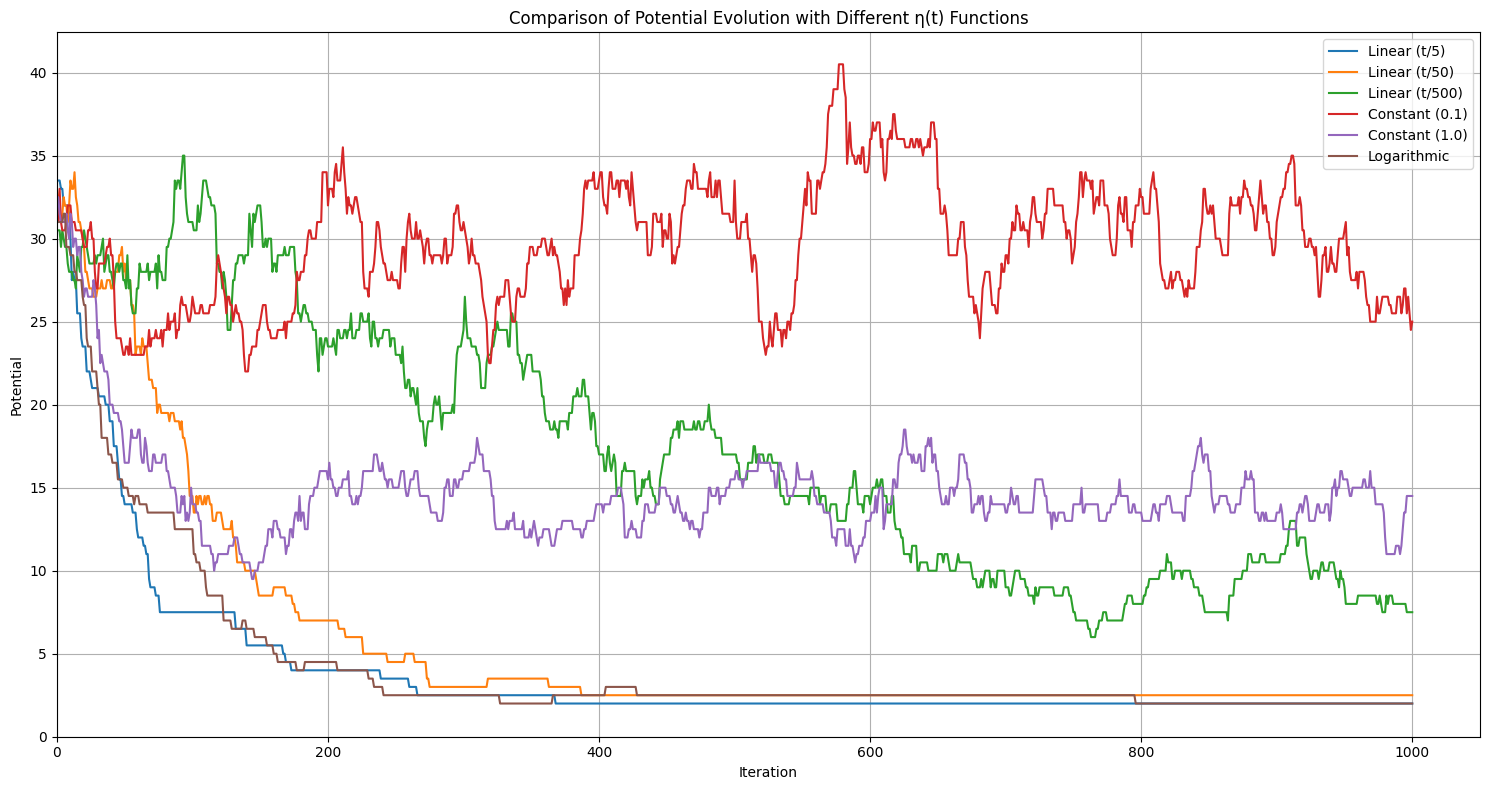


Final Potentials for Different η(t) Functions:
Linear (t/5): 2.00
Linear (t/50): 2.50
Linear (t/500): 7.50
Constant (0.1): 25.00
Constant (1.0): 14.50
Logarithmic: 2.00


In [117]:
# Define different η(t) functions
eta_funcs = {
    'Linear (t/5)': lambda t: t / 5,
    'Linear (t/50)': lambda t: t / 50,
    'Linear (t/500)': lambda t: t / 500,
    'Constant (0.1)': lambda t: 0.1,
    'Constant (1.0)': lambda t: 1.0,
    'Logarithmic': lambda t: np.log1p(t)
}

# Run simulations with different η(t) functions
results = {}
n_iterations = 1000

for name, eta_func in eta_funcs.items():
    _, potential_history = simulate(adj_matrix, wifi_channels, eta_func, wifi_cost, n_iterations)
    results[name] = potential_history

# Visualize the results
plt.figure(figsize=(15, 8))
for name, potentials in results.items():
    plt.plot(potentials, label=name)

plt.title('Comparison of Potential Evolution with Different η(t) Functions')
plt.xlabel('Iteration')
plt.ylabel('Potential')
plt.legend(loc='upper right')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()
plt.grid(True)
plt.show()

# Final statistics
final_potentials = {name: potentials[-1] for name, potentials in results.items()}
print("\nFinal Potentials for Different η(t) Functions:")
for name, potential in final_potentials.items():
    print(f"{name}: {potential:.2f}")